In [1]:
import _readData # read my csv file to data frame
import _visualize # generate charts from my data frames

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model # type: ignore

In [3]:
# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [4]:
df = _readData.reading('myData_MBB_priceHistory_20240321.csv')

r:\HOA18AO\stock price prediction\_readData.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3120 entries, 2024-03-21 to 2011-02-11
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3120 non-null   datetime64[ns]
 1   open     3120 non-null   float64       
 2   highest  3120 non-null   float64       
 3   lowest   3120 non-null   float64       
 4   close    3120 non-null   float64       
 5   volume   3120 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 170.6 KB


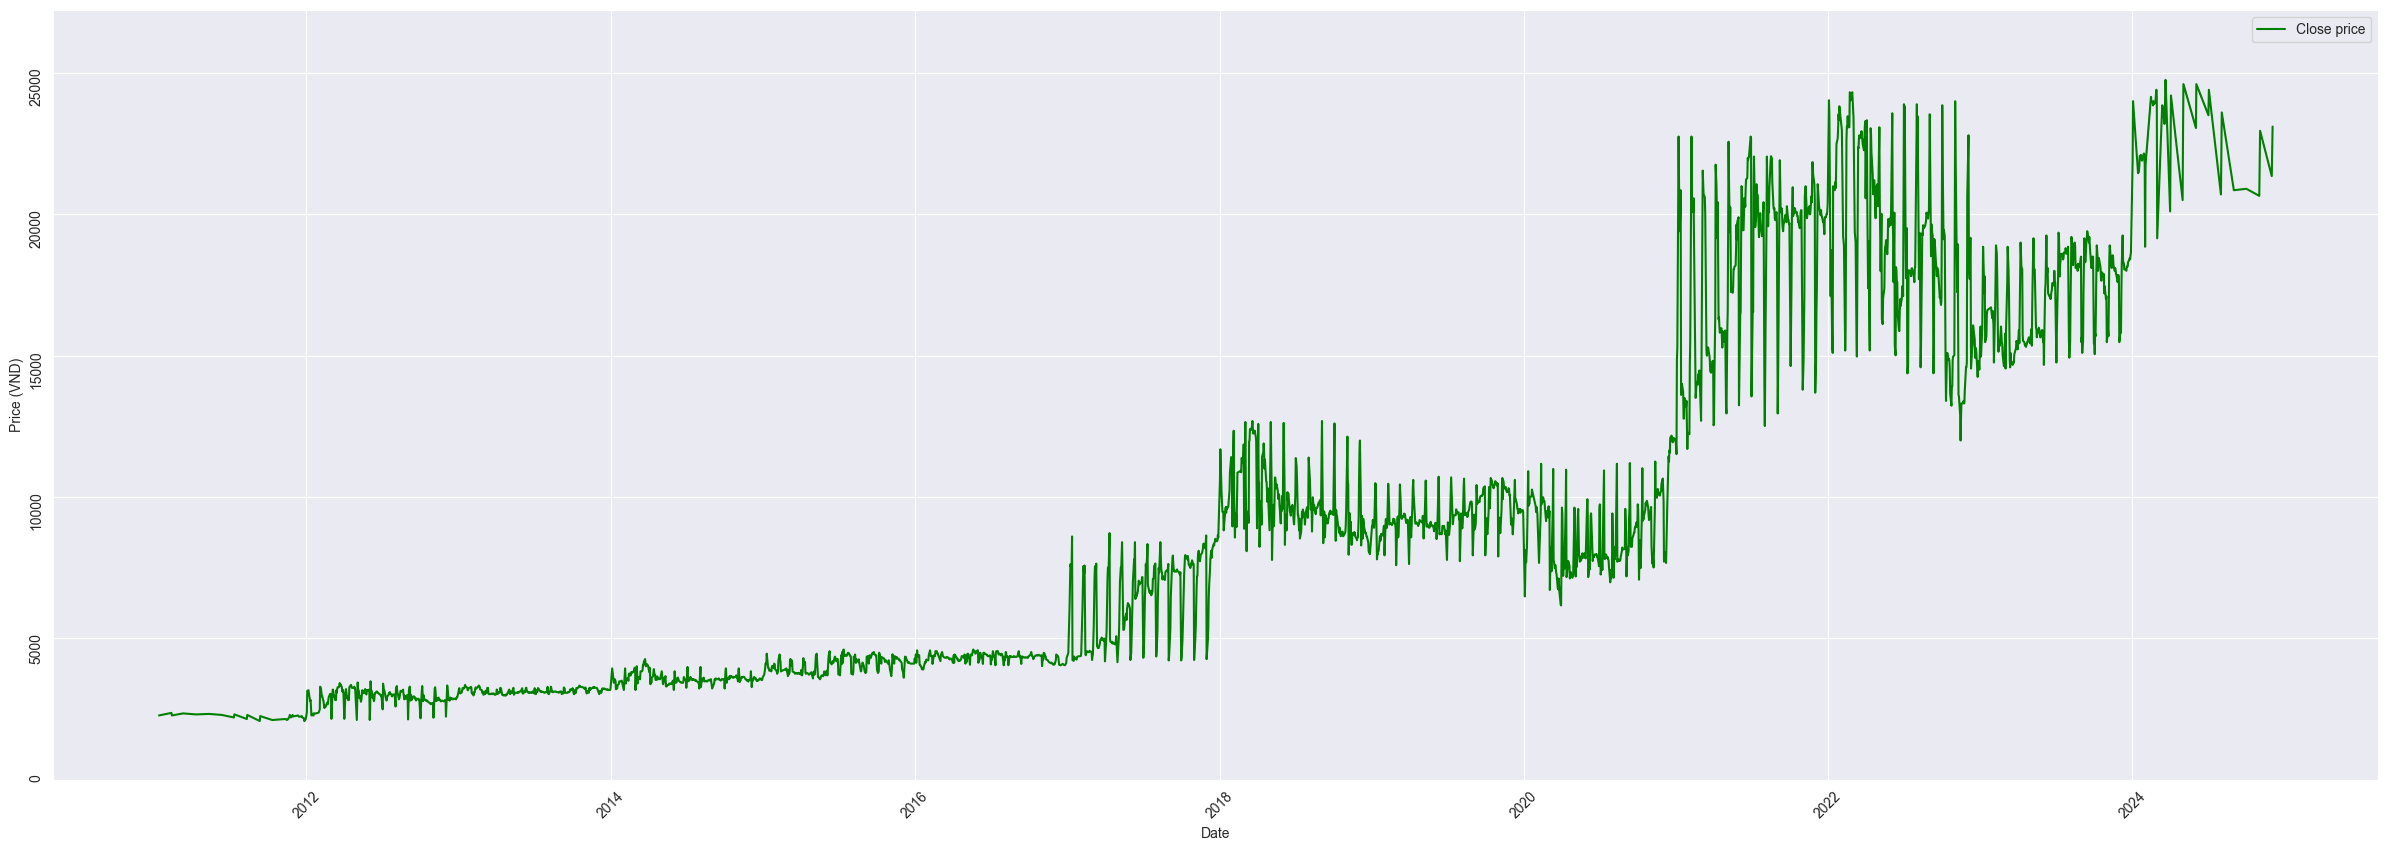

In [7]:
_visualize.drawChart2(df)

In [8]:
df = _readData.cleaning(df)
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,23200.0,24400.0,23100.0,24150.0,39357200,24750.0
2024-03-19,23200.0,23350.0,22950.0,23200.0,13605300,24150.0
2024-03-18,23750.0,23800.0,22400.0,23200.0,31782600,23200.0
2024-03-15,23450.0,23850.0,23150.0,23800.0,18886100,23200.0
2024-03-14,23950.0,23950.0,23400.0,23450.0,18358800,23800.0
...,...,...,...,...,...,...
2011-08-11,2171.0,2189.0,2117.0,2153.0,1105490,2081.0
2011-07-11,2315.0,2315.0,2207.0,2207.0,1221163,2153.0
2011-04-11,2369.0,2369.0,2315.0,2315.0,483860,2207.0


Scaling data

1. scale each column -> the scores are great but the actual predict is suck
2. scale all columns at once -> same result like last method
3. scale only the 'volume' -> same thing happened
4. scale all but the 'volume' -> eh
5. scale 'volume' and the others with different scaler ->it seems that your model is performing very well on the task for which it was trained

In [9]:
scaler_volume = MinMaxScaler().fit(df['volume'].values.reshape(-1, 1))
scaler_prices = MinMaxScaler().fit(df[['open', 'close', 'highest', 'lowest', 'tomorrow_close']].values.reshape(-1, 1))
scaler_prices, scaler_volume

(MinMaxScaler(), MinMaxScaler())

In [10]:
df.columns

Index(['open', 'highest', 'lowest', 'close', 'volume', 'tomorrow_close'], dtype='object')

In [11]:
for col in df.columns:
    if col == 'volume':
        df[col] = pd.DataFrame(scaler_volume.transform(df[col].values.reshape(-1, 1)), index=df.index)
    elif col in ['open', 'highest', 'lowest', 'close', 'tomorrow_close']:
        df[col] = pd.DataFrame(scaler_prices.transform(df[col].values.reshape(-1, 1)), index=df.index)
        
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,0.915599,0.967538,0.911271,0.956717,0.531356,0.982687
2024-03-19,0.915599,0.922091,0.904778,0.915599,0.183188,0.956717
2024-03-18,0.939404,0.941569,0.880973,0.915599,0.428946,0.915599
2024-03-15,0.926420,0.943733,0.913435,0.941569,0.254585,0.915599
2024-03-14,0.948061,0.948061,0.924256,0.926420,0.247456,0.941569
...,...,...,...,...,...,...
2011-08-11,0.005410,0.006189,0.003073,0.004631,0.014190,0.001515
2011-07-11,0.011643,0.011643,0.006968,0.006968,0.015754,0.004631
2011-04-11,0.013980,0.013980,0.011643,0.011643,0.005786,0.006968


In [12]:
df.to_numpy()[0]

array([0.91559903, 0.96753809, 0.91127078, 0.95671745, 0.53135551,
       0.98268698])

In [13]:
dfValues = df.values
# create sequences of data X and target Y for training
X = []
Y = []
# number of days to look back is 30 days
look_back = 30
for i in range(len(dfValues) - look_back):
    X.append(dfValues[i : i + look_back, [0, 1, 2, 3, 4]]) # sequence of 30 days
    Y.append(dfValues[i + look_back, [5]]) # close price of next day

X = np.array(X) # contain 'open','highest', 'lowest', 'close', 'volume' of 30 days (respectively) or the predictors
Y = np.array(Y) # contain 'close_tomorrow', which is the exact close price of the next day, which is the target that we want to predict

In [14]:
# lstm need differnct set of X, which is 3 dimensions
lstm_X = X
lstm_Y = Y

In [15]:
# turn X from 3 dimesions to 2 dimensions, for other machine learning models
tmp_X = [] # tmp_X is used for swap calue with X, keep up
for i in range(len(X)):
    tmp_X.append(X[i].reshape(-1))

X, tmp_X = tmp_X, X
X[0].size # == 150, because it 30 days multiple by 5 features (which features?)

150

In [16]:
len(lstm_X), len(lstm_Y)

(3089, 3089)

In [17]:
len(Y), len(X) # make sure that len(X) == len(Y)

(3089, 3089)

In [18]:
# create train-test sets
splitPoint = int(0.7 * len(X)) # lenX == lenY, train set == 70%
X_train = X[:splitPoint]
X_test  = X[splitPoint:]
Y_train = Y[:splitPoint]
Y_test  = Y[splitPoint:]

LSTM (Long Short-term Memories)-----------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
# prepare train-test set for lstm model
# splitPoint is existed, make sure train set is about 70% of the whole dataset
lstm_X_train = lstm_X[:splitPoint]
lstm_X_test  = lstm_X[splitPoint:]
lstm_Y_train = lstm_Y[:splitPoint]
lstm_Y_test  = lstm_Y[splitPoint:]

In [20]:
# import models
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
#from keras.layers import RNN

In [21]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(30, 5)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [22]:
save_model = 'savedModel_LSTM.h5'
best_choice = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size=32, callbacks=[best_choice])

Epoch 1/10
67/68 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 1: loss improved from inf to 0.01589, saving model to savedModel_LSTM.h5
68/68 [==============================] - 2s 8ms/step - loss: 0.0159
Epoch 2/10
62/68 [==========================>...] - ETA: 0s - loss: 5.2916e-04
Epoch 2: loss improved from 0.01589 to 0.00053, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 8ms/step - loss: 5.2882e-04
Epoch 3/10
62/68 [==========================>...] - ETA: 0s - loss: 3.9070e-04
Epoch 3: loss improved from 0.00053 to 0.00039, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 8ms/step - loss: 3.8723e-04
Epoch 4/10
67/68 [============================>.] - ETA: 0s - loss: 3.0685e-04
Epoch 4: loss improved from 0.00039 to 0.00031, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 8ms/step - loss: 3.0641e-04
Epoch 5/10
63/68 [==========================>...] - ETA: 0s - loss: 2.5523e-

In [23]:
loss = model.evaluate(lstm_X_test, lstm_Y_test)
lstm_Y_pred = model.predict(lstm_X_test)
r2 = r2_score(lstm_Y_test, lstm_Y_pred)
mae = mean_absolute_error(lstm_Y_test, lstm_Y_pred)
#loss # mse

29/29 [==============================] - 0s 3ms/step


In [24]:
print('LSTM:\nr2 :', r2, '\nmean absolute error : ', mae, '\nmean squared error : ', loss)

LSTM:
r2 : 0.9502117043530764 
mean absolute error :  0.0035872453385730465 
mean squared error :  2.02025257749483e-05


Random Forest ------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
import joblib # for saving models weights
from sklearn.ensemble import RandomForestRegressor

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [27]:
rf_model.fit(X,Y) # turn this to rf_X_train/test and ...
rf_model

c:\Users\tranh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [28]:
joblib.dump(rf_model, 'savedModel_RandomForest.h5')

['savedModel_RandomForest.h5']

In [29]:
rf_Y_pred = rf_model.predict(X_test)
rf_Y_pred

array([0.10131319, 0.10241949, 0.10481389, 0.10606086, 0.10483466,
       0.10242123, 0.10133094, 0.10134046, 0.10243248, 0.10132921,
       0.10358639, 0.1107094 , 0.11069728, 0.10605696, 0.10011946,
       0.10012119, 0.09651186, 0.09538565, 0.09537007, 0.09423563,
       0.08938063, 0.0917577 , 0.09652831, 0.09302545, 0.09539344,
       0.09762725, 0.10012812, 0.09889716, 0.09057739, 0.09176376,
       0.09302285, 0.09176376, 0.0882081 , 0.07744243, 0.07624827,
       0.077442  , 0.07625173, 0.07864829, 0.0774472 , 0.07623788,
       0.07622749, 0.07743854, 0.08092755, 0.07623442, 0.07737881,
       0.07144737, 0.071424  , 0.07033111, 0.07140322, 0.07026013,
       0.06906813, 0.06665772, 0.06549342, 0.06786704, 0.06907462,
       0.06907895, 0.06787136, 0.07027311, 0.07262768, 0.07148632,
       0.07148286, 0.07262552, 0.07151705, 0.07619243, 0.07389327,
       0.07383527, 0.07266015, 0.07265235, 0.07384003, 0.07503333,
       0.07505194, 0.07506363, 0.07384003, 0.07505194, 0.07505

In [30]:
print(
    'Random Forest:\n',
    'r2 : ', r2_score(rf_Y_pred, rf_Y_test), '\n',
    'mae : ', mean_absolute_error(rf_Y_pred, rf_Y_test), '\n',
    'mse : ', mean_squared_error(rf_Y_pred, rf_Y_test), '\n',
    'rmse : ', root_mean_squared_error(rf_Y_pred, rf_Y_test)
)

NameError: name 'rf_Y_test' is not defined

XGBoots -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Specify the objective function for regression task (minimize squared error)
    n_estimators=100,               # Number of boosting rounds (trees) to build
    max_depth=5,                    # Maximum depth of each tree
    learning_rate=0.1,              # Learning rate (shrinkage) of each tree's contribution
    gamma=0,                        # Minimum loss reduction required to make a further partition on a leaf node
    subsample=0.8,                  # Subsample ratio of the training instances (prevent overfitting)
    colsample_bytree=0.8,           # Subsample ratio of columns when constructing each tree
    random_state=42                 # Random seed for reproducibility
)

In [ ]:
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_Y_pred = xgb_model.predict(X_test)
print(
    'XGBOOST:\n',
    'r2 : ', r2_score(xgb_Y_pred, Y_test), '\n',
    'mae : ', mean_absolute_error(xgb_Y_pred, Y_test), '\n',
    'mse : ', mean_squared_error(xgb_Y_pred, Y_test), '\n',
    'rmse : ', root_mean_squared_error(xgb_Y_pred, Y_test)
)

XGBOOST:
 r2 :  0.9747356623152699 
 mae :  0.0027316236598556726 
 mse :  2.8596050815169217e-05 
 rmse :  0.005347527542254384


ARIMA (Auto Regressive Integrated Moving Average) ImportError: numpy.core.multiarray failed to import

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Define ARIMA model parameters (p, d, q)
# p = 1  # Autoregressive order (AR)
# d = 1  # Differencing order (I)
# q = 1  # Moving average order (MA)
arm_model = ARIMA(Y_train, order=[1, 1, 1])
arm_model = arm_model.fit()

In [ ]:
arm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3002
Model:                 ARIMA(1, 1, 1)   Log Likelihood               11221.154
Date:                Wed, 17 Apr 2024   AIC                         -22436.308
Time:                        05:04:55   BIC                         -22418.288
Sample:                             0   HQIC                        -22429.826
                               - 3002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1740      0.283     -0.614      0.539      -0.729       0.381
ma.L1          0.2023      0.281      0.719      0.472      -0.349       0.754
sigma2      3.306e-05   2.85e-07    115.835      0.000    3.25e-05    3.36e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31753.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""